<a href="https://colab.research.google.com/github/LeeHuiJong/Deep_learning/blob/main/ch04_06_Autoencoder_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.06 AutoEncoder

* 날짜:
* 이름:

## 학습내용
    - AutoEncoder를 이해하고 구현한다.
    - Denoising 을 적용해 본다. 
    - 이상치 탐지를 적용해 본다. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys, os
sys.path.append('/content/drive/MyDrive/script')
from lib import *

ModuleNotFoundError: ignored

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## AutoEncoder 기본 구현
---

![](https://gaussian37.github.io/assets/img/dl/concept/autoencoder2/autoencoder.png)

### **| 모델 구성**

In [30]:
# 이미지 -> 이미지 normalize = x/255 x값이 0~1 사이 (0 또는 1이 아니다.)

# mnist: 28 x 28 =784
def create_model(input_dims=784):
  # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Dense(128, activation='relu')(x)
  z = layers.Dense(64, activation='relu')(z)
  z = layers.Dense(16, activation='relu')(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(64, activation='relu')(z)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dense(input_dims, activation='sigmoid')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

  return encoder, decoder, model

def create_cnn(input_dims=784):
    # encoder
  x = layers.Input(shape=input_dims, name='x')
  z = layers.Conv2D(32, 3, padding = 'same', activation='relu')(x)
  z = layers.Conv2D(64, 3, stride = 2 activation='relu')(z)
  z = layers.Conv2D(64, 3, stride = 2, padding = 'same' activation='relu')(z)
  z = layers.Conv2D(64, 3, padding = 'same' activation='relu')(z)
  z = flatten()(z)
  encoder = models.Model(x, z, name='Encoder')

  # decoder
  y = layers.Dense(7*7*64)(z)
  y = layers.Conv2DTranspose(64, 3, stride = 1, padding = 'same', activation='relu')(y)
  y = layers.Conv2DTranspose(64, 3, stride = 2, padding = 'same', activation='relu')(y)
  y = layers.Conv2DTranspose(64, 3, stride = 2, padding = 'same', activation='relu')(y)
  y = layers.Conv2DTranspose(32, 3, stride = 1, padding = 'same', activation='relu')(y)
  decoder = models.Model(z, y, name='Decoder')

  # AutoEncoder
  z = encoder(x)
  y = decoder(z)
  model = models.Model(x, y, name='AutoEncoder')
  model.compile(loss= 'mse', 
                optimizer='adam')

  model.summary()

In [31]:
encoder, decoder, model = create_cnn()

TypeError: ignored

### **| 학습**

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# norm
x_train = x_train / 255.0
x_test = x_test / 255.

# flatten
x_train = x_train.reshape( (60000, -1) )
x_test = x_test.reshape( (10000, -1) )

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [14]:
history = model.fit(x_train, x_train, epochs = 50, batch_size = 128)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0490
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0258
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0217
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0199
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0179
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0171
Epoch 8/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0164
Epoch 9/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0159
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 11/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0151
Epoch 12/50
469/469 [==============================] - 2s 4ms/step - loss: 0.0148
Epoch 13/50
469/469 [====

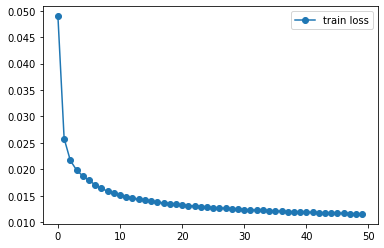

In [15]:
l = history.history['loss']
plt.plot(l, marker= 'o', label = 'train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [16]:
x_recon = model.predict(x_test)
x_test.shape, x_recon.shape

((10000, 784), (10000, 784))

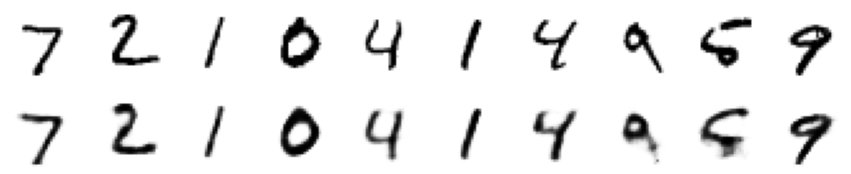

In [17]:
def display_res(org, rec):
  plt.figure(figsize = (15,3))
  for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(org[i].reshape(28,28), cmap = 'gray_r')
    plt.axis('off')
    plt.subplot(2, 10, i+11)
    plt.imshow(rec[i].reshape(28,28), cmap = 'gray_r')
    plt.axis('off')
  plt.show()

display_res(x_test, x_recon)

In [18]:
z = encoder(x_test[:1000])
z.shape

TensorShape([1000, 16])

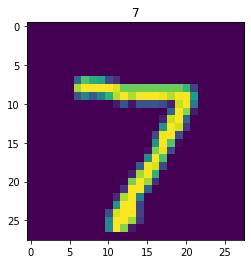

In [30]:
plt.title(y_test[0])
plt.imshow(x_test[0].reshape(28,28))

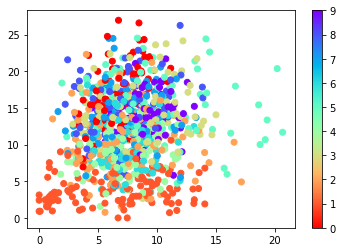

In [20]:
plt.scatter(z[:,1], z[:,2], c=y_test[:1000], cmap='rainbow_r')
plt.colorbar()

## AutoEncoder 활용 - Denoising
---

### **| 데이터 준비**

(60000, 784) (10000, 784)


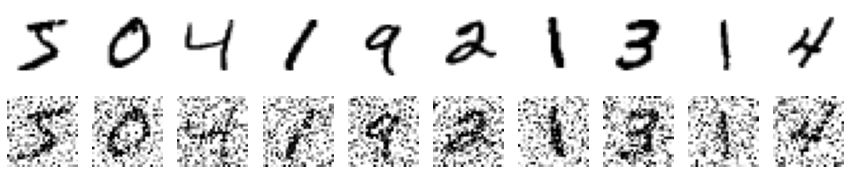

In [23]:
train_noise = np.random.normal(size = x_train.shape)
test_noise = np.random.normal(size = x_test.shape)

factor = 0.5
x_train_noisy = x_train + train_noise * factor
x_test_noisy = x_test + test_noise * factor

# 0~1 범위를 벗어나지 않도록
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(train_noise.shape, test_noise.shape)
display_res(x_train, x_train_noisy)

### **| 훈련**

In [24]:
history = model.fit(x_train_noisy, x_train, epochs = 50, batch_size = 128)

Epoch 1/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0275
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0217
Epoch 3/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0206
Epoch 4/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0201
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0197
Epoch 6/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0193
Epoch 7/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0191
Epoch 8/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0189
Epoch 9/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 10/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0186
Epoch 11/50
469/469 [==============================] - 2s 3ms/step - loss: 0.0184
Epoch 12/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0183
Epoch 13/50
469/469 [====

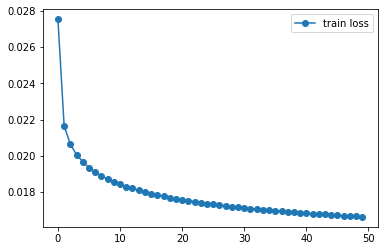

In [25]:
l = history.history['loss']
plt.plot(l, marker= 'o', label = 'train loss')
plt.legend()
plt.show()

### **| 결과 확인**

In [28]:
x_recon = model.predict(x_test_noisy)
x_recon.shape, x_test_noisy.shape

((10000, 784), (10000, 784))

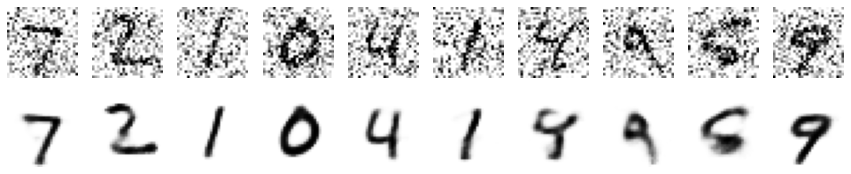

In [29]:
display_res(x_test_noisy, x_recon)

## AutoEncoder 활용 - 이상치 탐지
---

### **| 모델 구성**

### **| 데이터 준비**


### **| 훈련**

### **| 결과 확인**